# Chronos - Basic Usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

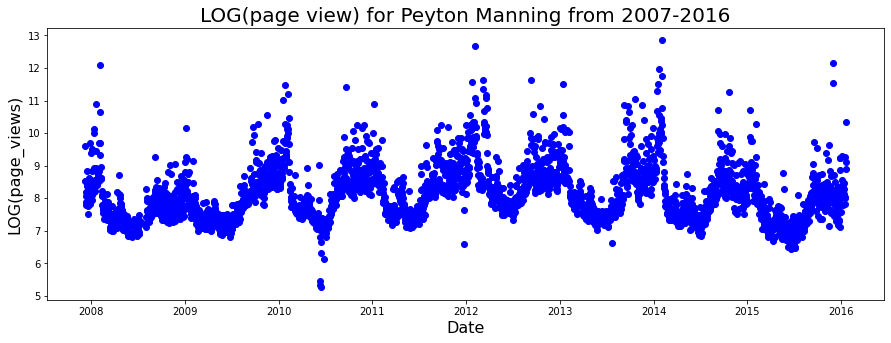

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [5]:
from chronos import Chronos

In [6]:
my_chronos = Chronos(method="MAP", max_iter=1000, learning_rate=0.1)
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: 0.6526                                                                          


In [7]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
3265,2017-01-15,NaN
3266,2017-01-16,NaN
3267,2017-01-17,NaN
3268,2017-01-18,NaN


In [8]:
predictions = my_chronos.predict(future_df, sample_number=1000)

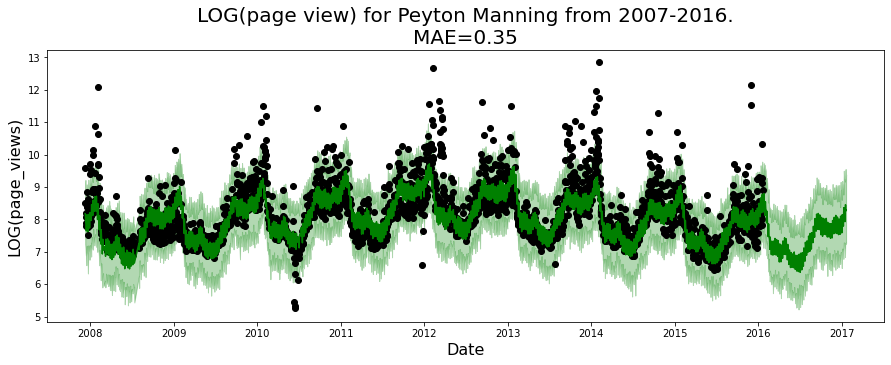

In [9]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016.\nMAE={MAE}", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

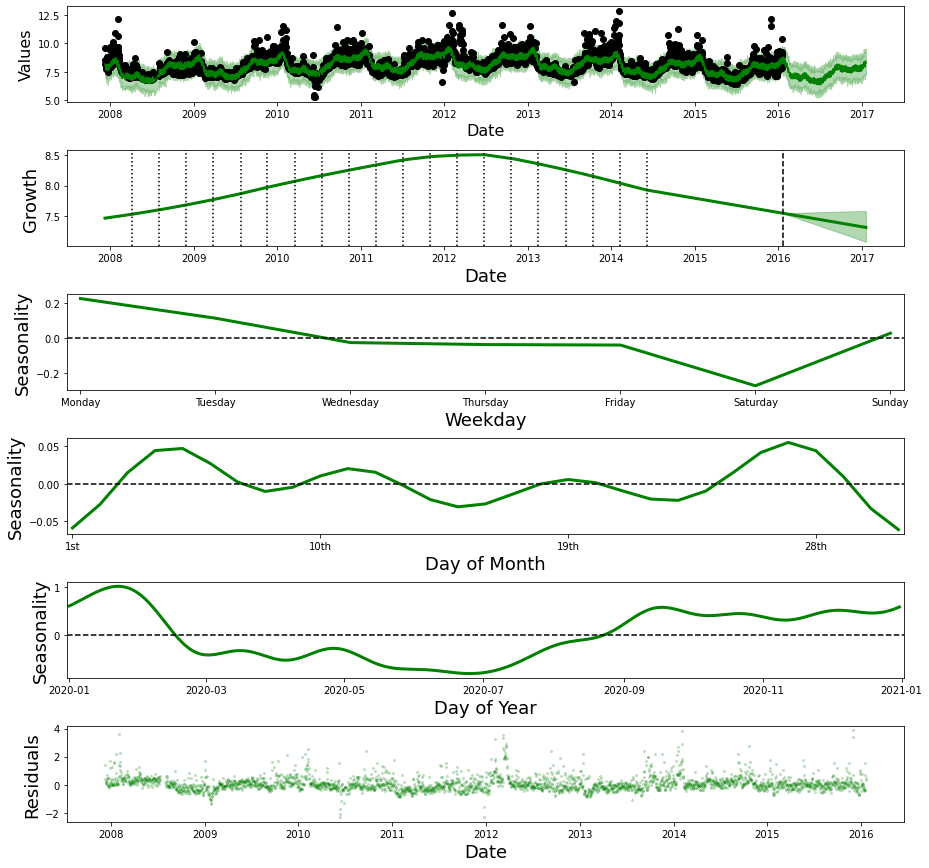

In [10]:
my_chronos.plot_components(predictions)

## AAPL stocks

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [12]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


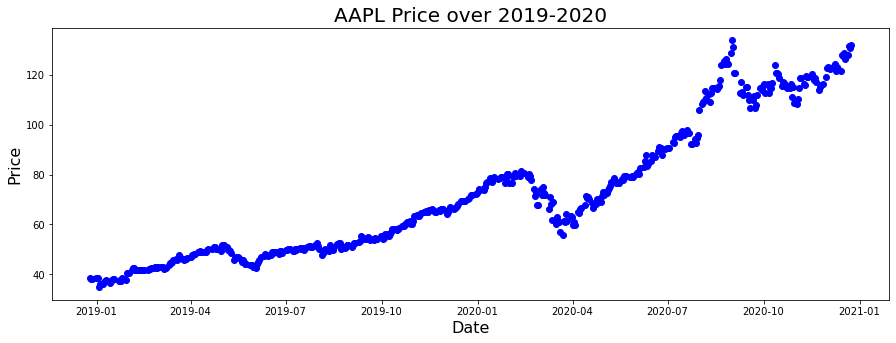

In [13]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [44]:
my_chronos = Chronos(method="MLE", max_iter=10000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation
100.0% - ELBO loss: 2.5034                                                                          


In [49]:
future_df = my_chronos.make_future_dataframe(period=62)
future_df

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561
...,...,...
562,2021-02-20,NaN
563,2021-02-21,NaN
564,2021-02-22,NaN
565,2021-02-23,NaN


In [50]:
predictions = my_chronos.predict(future_df, sample_number=1000)

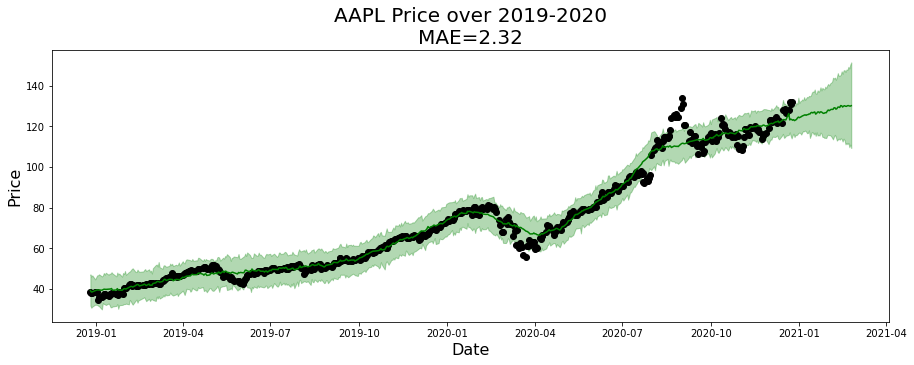

In [51]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020\nMAE={MAE}", size=20)
plt.show()

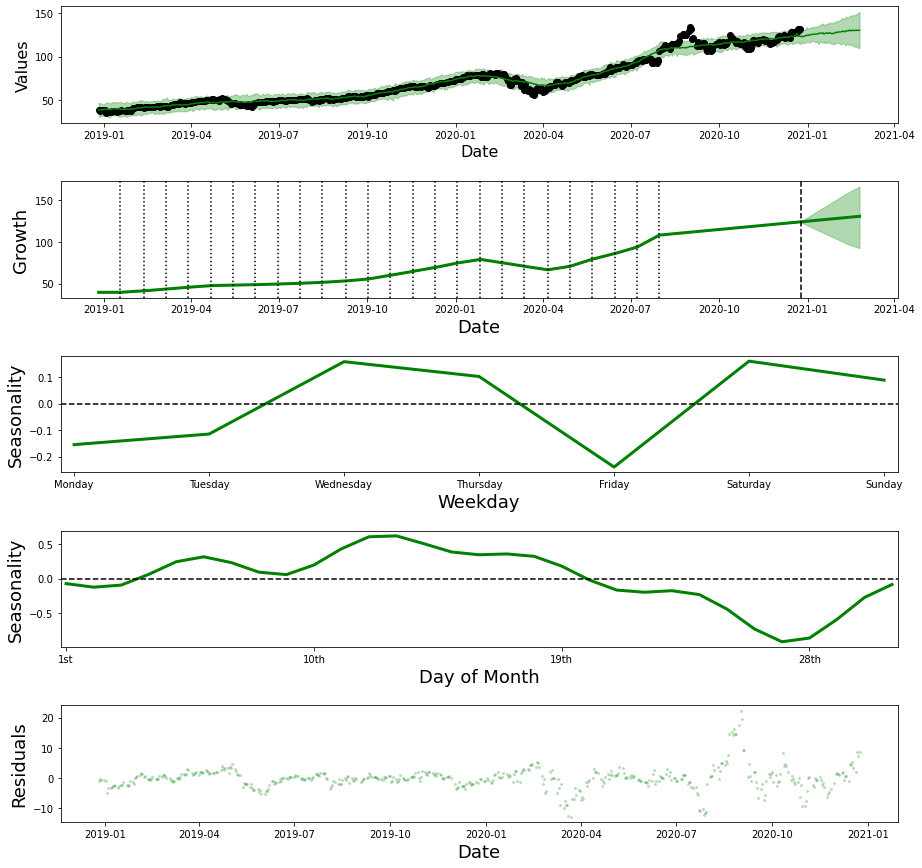

In [52]:
my_chronos.plot_components(predictions, figure_name="AAPL.png")

In [ ]:
------------

started at 855 lines

In [ ]:
class Chronos:
    
    
    def __init__

    def fit
    
    def combine_components
    
    def add_future_changepoints
    
    def compute_trend

    def make_future_dataframe
    
    def compute_seasonality
    
    def get_weekly_seasonality
    
    def get_seasonal_params
    
    def get_seasonal_plotly_figure
    
    def get_weekly_seasonality_point
    
    def plot_components
    
    def plot_weekly_seasonality
    
    def plot_weekly_seasonality_plotly
    
    def get_monthly_seasonality
    
    def get_monthly_seasonality_point
    
    def plot_monthly_seasonality
    
    def plot_monthly_seasonality_plotly
    
    def get_yearly_seasonality
    
    def get_yearly_seasonality_point
    
    def plot_yearly_seasonality
    
    def plot_yearly_seasonality_plotly

In [ ]:
class Chronos:
    
    
    def __init__
        
    def transform_data_
                
    def find_changepoint_positions
        
    def make_A_matrix

    def fit
        
    def train_MCMC
    
    def train_point_estimate
    
    def combine_components
    
    def model_MLE_
    
    def guide_MLE_
    
    def get_trend
    
    def model_MAP_
    
    def model_MAP_gamma
        
    def predict

    def make_future_dataframe
    
    def compute_seasonality
    
    def get_weekly_seasonality
    
    def get_seasonal_params
    
    def get_seasonal_plotly_figure
    
    def get_weekly_seasonality_point
    
    def plot_components
    
    def plot_weekly_seasonality
    
    def plot_weekly_seasonality_plotly
    
    def get_monthly_seasonality
    
    def get_monthly_seasonality_point
    
    def plot_monthly_seasonality
    
    def plot_monthly_seasonality_plotly
    
    def get_yearly_seasonality
    
    def get_yearly_seasonality_point
    
    def plot_yearly_seasonality
    
    def plot_yearly_seasonality_plotly